In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix

import MVP_Davila, MVP_Shi

## 1st Iteration

### Acquire the train.csv

In [2]:
# Loade the csv files
train = pd.read_csv("train.csv")

# Inspect the shapes
train.shape

(101230332, 10)

In [3]:
# Take a quck peek of the dataframe
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [4]:
# Summarize the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


**Takeaways**
- The train dataset has more than 100 millions records. I only need to small portion to calculate the statistics of the past.<br>
    -**I will take the first 1000 user ids.**

### Subtract the records of the first 1000 users

In [22]:
# Extract the first 1000 user ids

user_ids1000 = train.user_id.value_counts().sort_index().iloc[0: 1000]
user_ids1000 = user_ids1000.index.to_list()

# Sanity check
print(len(user_ids1000))

# Print the first 5 user ids
user_ids1000[:5]

1000


[115, 124, 2746, 5382, 8623]

In [23]:
# Set the user_id to the index

train = train.set_index("user_id")
train.head()

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,0,0,5692,0,1,3,1,NaN,NaN
115,1,56943,5716,0,2,2,1,37000.0,False
115,2,118363,128,0,0,0,1,55000.0,False
115,3,131167,7860,0,3,0,1,19000.0,False
115,4,137965,7922,0,4,1,1,11000.0,False


In [24]:
# Subtracts the records for the first 1000 users
train1000 = train.loc[user_ids1000]

# Take a peek at the new dataset
train1000.head()

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,0,0,5692,0,1,3,1,NaN,NaN
115,1,56943,5716,0,2,2,1,37000.0,False
115,2,118363,128,0,0,0,1,55000.0,False
115,3,131167,7860,0,3,0,1,19000.0,False
115,4,137965,7922,0,4,1,1,11000.0,False


In [25]:
# Sanity check
train1000.tail() # should match the tail of user_ids1000

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
5577726,296610,625311764,5328,0,7,0,0,20000.0,False
5577726,296611,625327721,4303,0,8,3,0,10000.0,True
5577726,296612,625344560,4445,0,9,0,1,6000.0,True
5577726,296613,625367161,5206,0,10,1,0,6000.0,True
5577726,296614,625378759,3928,0,11,0,0,13000.0,True


In [26]:
# Print the tail of the user_ids1000
user_ids1000[999]

5577726

In [27]:
# Read the train1000.csv
train1000 = pd.read_csv("train1000.csv", index_col=0)

In [28]:
# Quick summarize the train1000
train1000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296615 entries, 115 to 5577726
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          296615 non-null  int64  
 1   timestamp                       296615 non-null  int64  
 2   content_id                      296615 non-null  int64  
 3   content_type_id                 296615 non-null  int64  
 4   task_container_id               296615 non-null  int64  
 5   user_answer                     296615 non-null  int64  
 6   answered_correctly              296615 non-null  int64  
 7   prior_question_elapsed_time     289945 non-null  float64
 8   prior_question_had_explanation  295617 non-null  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 22.6+ MB


In [29]:
# Count how many missing values in the prior_question_elapsed_time

mask = train1000.prior_question_elapsed_time.isnull()
mask.sum()

6670

In [30]:
# Count how many missing values in the prior_question_had_explanation

mask = train1000.prior_question_had_explanation.isnull()
mask.sum()

998

**Takeaways**
- The memoery usage of the first 1000 users are only 23 MB
- Missing values are found in columns:
    - prior_question_elapsed_time: 6670 nulls
    - prior_question_had_explanantion: 998 nulls

### Handling the null values

In [31]:
# The values of the two prior columns will always be 0 when the user first interacted with the system
# Take a first user 115 for example

train1000.loc[115].head()

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,0,0,5692,0,1,3,1,NaN,NaN
115,1,56943,5716,0,2,2,1,37000.0,False
115,2,118363,128,0,0,0,1,55000.0,False
115,3,131167,7860,0,3,0,1,19000.0,False
115,4,137965,7922,0,4,1,1,11000.0,False


**Takeawasy**
- There are only 1000 users so the two prior columns should have at leat 1000 nulls.
- The prior_question_had_explanantion column has 998 nulls:
    - fill the nulls with False
- I will further explore the missing values in the column prior_question_elapased_time.

### Fill the nulls in the prior_question_had_explanation with string False

In [32]:
train1000.prior_question_had_explanation.fillna(False, inplace = True)
train1000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296615 entries, 115 to 5577726
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          296615 non-null  int64  
 1   timestamp                       296615 non-null  int64  
 2   content_id                      296615 non-null  int64  
 3   content_type_id                 296615 non-null  int64  
 4   task_container_id               296615 non-null  int64  
 5   user_answer                     296615 non-null  int64  
 6   answered_correctly              296615 non-null  int64  
 7   prior_question_elapsed_time     289945 non-null  float64
 8   prior_question_had_explanation  296615 non-null  bool   
dtypes: bool(1), float64(1), int64(7)
memory usage: 30.6 MB


In [33]:
train1000.prior_question_had_explanation.value_counts()

True     267494
False     29121
Name: prior_question_had_explanation, dtype: int64

In [34]:
mask = train1000.prior_question_elapsed_time.isnull()
train1000[mask]

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,0,0,5692,0,1,3,1,NaN,False
124,46,0,7900,0,0,0,1,NaN,False
2746,76,0,5273,0,0,1,0,NaN,False
2746,89,653762,6808,1,14,-1,-1,NaN,False
5382,96,0,5000,0,0,0,1,NaN,False
...,...,...,...,...,...,...,...,...,...
5566848,296498,162115714,32168,1,21,-1,-1,NaN,False
5568049,296509,0,6028,0,0,3,0,NaN,False
5568049,296537,7746409318,24250,1,20,-1,-1,NaN,False


**Takeaways**
- When the user studies the lecture, the prior_question_elapsed_time documented as NaN.
- I will fill the missing values in the columsn prior_question_elapsed_time with 0.

### Fill the nulls in the prior_question_elapsed_time with string 0

In [35]:
train1000.prior_question_elapsed_time.fillna(0, inplace = True)
train1000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296615 entries, 115 to 5577726
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          296615 non-null  int64  
 1   timestamp                       296615 non-null  int64  
 2   content_id                      296615 non-null  int64  
 3   content_type_id                 296615 non-null  int64  
 4   task_container_id               296615 non-null  int64  
 5   user_answer                     296615 non-null  int64  
 6   answered_correctly              296615 non-null  int64  
 7   prior_question_elapsed_time     296615 non-null  float64
 8   prior_question_had_explanation  296615 non-null  bool   
dtypes: bool(1), float64(1), int64(7)
memory usage: 30.6 MB


**Takeawasy**
- All the null values have been addressed in the dataset. 

### Split the train1000 into train and test

In [36]:
# Double check the 1000 user_id list
print(len(user_ids1000))
user_ids1000[:5]

1000


[115, 124, 2746, 5382, 8623]

In [126]:
# Create the train and test dataframe

train = pd.DataFrame()
test = pd.DataFrame()

# Set up the train size
train_size = 0.8

for user_id in user_ids1000:
    if train1000.loc[[user_id]].shape[0] <=2:
        print(user_id)
        continue
    elif train1000.loc[[user_id]].shape[0] > 2: 
        df = train1000.loc[[user_id]]
        n = df.shape[0]
        test_start_index = round(train_size * n)
        df_train = df.iloc[:test_start_index]
        df_test = df.iloc[test_start_index:]     
        train = pd.concat([train, df_train])
        test = pd.concat([test, df_test])
    
# Print the shape of the original, train and test
train1000.shape, train.shape, test.shape

1880240
2148001


((296615, 9), (237322, 9), (59290, 9))

**Quick Notes: Such splitting methods will produce some problems in the future.**

In [127]:
# Take a peek at the train dataset
train.head(2)

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,0,0,5692,0,1,3,1,0.0,False
115,1,56943,5716,0,2,2,1,37000.0,False


In [128]:
# Take a peek at the test
test.head(2)

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,37,1415188,7882,0,37,2,1,20000.0,True
115,38,1468285,7962,0,38,3,1,17000.0,True


In [129]:
train.tail(2)

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
5577726,296611,625327721,4303,0,8,3,0,10000.0,True
5577726,296612,625344560,4445,0,9,0,1,6000.0,True


In [130]:
test.tail(2)

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
5577726,296613,625367161,5206,0,10,1,0,6000.0,True
5577726,296614,625378759,3928,0,11,0,0,13000.0,True


In [131]:
# Quick summarize the train
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237322 entries, 115 to 5577726
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          237322 non-null  int64  
 1   timestamp                       237322 non-null  int64  
 2   content_id                      237322 non-null  int64  
 3   content_type_id                 237322 non-null  int64  
 4   task_container_id               237322 non-null  int64  
 5   user_answer                     237322 non-null  int64  
 6   answered_correctly              237322 non-null  int64  
 7   prior_question_elapsed_time     237322 non-null  float64
 8   prior_question_had_explanation  237322 non-null  bool   
dtypes: bool(1), float64(1), int64(7)
memory usage: 16.5 MB


In [132]:
# Quick summarize the test
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59290 entries, 115 to 5577726
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          59290 non-null  int64  
 1   timestamp                       59290 non-null  int64  
 2   content_id                      59290 non-null  int64  
 3   content_type_id                 59290 non-null  int64  
 4   task_container_id               59290 non-null  int64  
 5   user_answer                     59290 non-null  int64  
 6   answered_correctly              59290 non-null  int64  
 7   prior_question_elapsed_time     59290 non-null  float64
 8   prior_question_had_explanation  59290 non-null  bool   
dtypes: bool(1), float64(1), int64(7)
memory usage: 4.1 MB


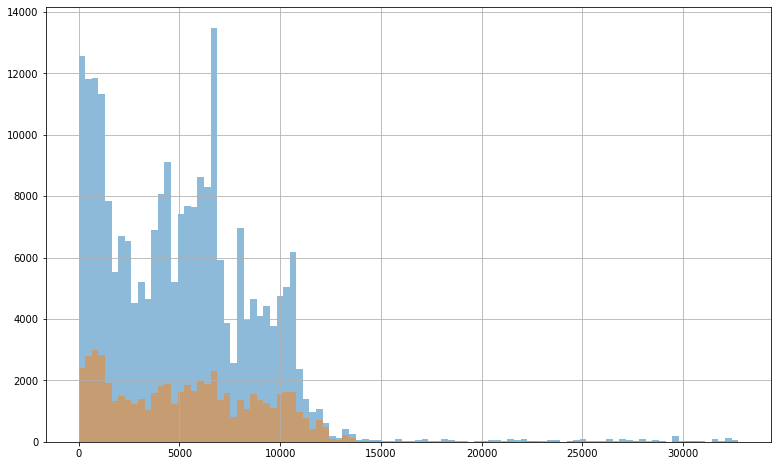

In [133]:
# View the distribution of content_id in train and test

plt.figure(figsize=(13, 8))
train.content_id.hist(bins=100, alpha=0.5)
test.content_id.hist(bins=100, alpha=0.5)

plt.show()

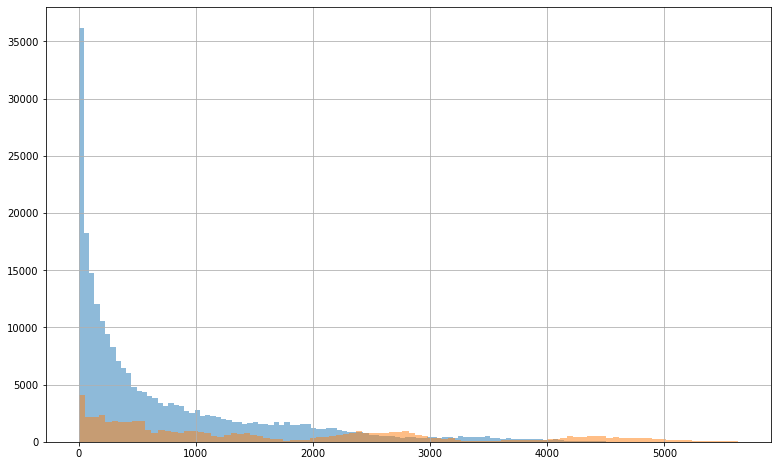

In [134]:
# View the distribution of task_container_id in train and test

plt.figure(figsize=(13, 8))
train.task_container_id.hist(bins=100, alpha=0.5)
test.task_container_id.hist(bins=100, alpha=0.5)

plt.show()

### Count how many lectures each user has reviewed in the train

In [135]:
# Create a new columns for if the student review the lecture or not

train['reviewed_lecture'] = (train['answered_correctly'] == -1)
train.head()

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,reviewed_lecture
user_id,,,,,,,,,,
115,0,0,5692,0,1,3,1,0.0,False,False
115,1,56943,5716,0,2,2,1,37000.0,False,False
115,2,118363,128,0,0,0,1,55000.0,False,False
115,3,131167,7860,0,3,0,1,19000.0,False,False
115,4,137965,7922,0,4,1,1,11000.0,False,False


In [136]:
# Compute how many times each user reviewed the lecture

count_reviewed_lecture_train = train.groupby(train.index).reviewed_lecture.sum()
count_reviewed_lecture_train

user_id
115        0
124        0
2746       1
5382       1
8623       2
          ..
5555086    0
5566848    2
5568049    1
5571864    0
5577726    0
Name: reviewed_lecture, Length: 998, dtype: int64

In [137]:
# Merger the new feature with test dataset

test = test.merge(count_reviewed_lecture_train, how="left", on='user_id')

count_reviewed_lecture_test = test.groupby(test.index).reviewed_lecture.sum()
count_reviewed_lecture_test

user_id
115         0
124         0
2746        4
5382       26
8623       44
           ..
5555086     0
5566848    14
5568049    15
5571864     0
5577726     0
Name: reviewed_lecture, Length: 998, dtype: int64

**Takeaways**
- The user didn't review the lecture in the train dataset but reference the lecture in the test dataset.
- It is relative complicated in codes, so just drop the column for now.

In [138]:
# Drop the reviewed_lecture columns

train.drop(columns='reviewed_lecture', inplace=True)
test.drop(columns='reviewed_lecture', inplace=True)

In [139]:
# Print the shapes
train.shape, test.shape

((237322, 9), (59290, 9))

### Drop the lecture rows in train and test

In [140]:
# Drop the lecture rows in train

mask = train['answered_correctly'] != -1
train = train[mask]

# Print the shape
train.shape

(232718, 9)

**Quick note**: the number of observations in the train drops from 237322 to 232718

In [141]:
# Drop the lecture rows in test

mask = test['answered_correctly'] != -1
test = test[mask]

# Print the shape
test.shape

(58222, 9)

**Quick note**: the number of observations in the test drops from 59290 to 58222.

In [142]:
# Reset the index in the train and test for the purpose of later merge

train.reset_index(inplace=True)
train.head()

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,0,0,5692,0,1,3,1,0.0,False
1,115,1,56943,5716,0,2,2,1,37000.0,False
2,115,2,118363,128,0,0,0,1,55000.0,False
3,115,3,131167,7860,0,3,0,1,19000.0,False
4,115,4,137965,7922,0,4,1,1,11000.0,False


In [143]:
# Reset the index in the train and test for the purpose of later merge

test.reset_index(inplace=True)
test.head()

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,37,1415188,7882,0,37,2,1,20000.0,True
1,115,38,1468285,7962,0,38,3,1,17000.0,True
2,115,39,667861680,1278,0,39,3,1,21000.0,False
3,115,40,667971812,2065,0,40,2,1,17000.0,False
4,115,41,667971812,2064,0,40,1,1,17000.0,False


### Feature engineering - To measure the statistics of the whole content
- content_id
- task_container_id

In [144]:
# Compute the statistics of the content by the the content_id

content_stats = train.groupby('content_id').answered_correctly.agg(['mean', 
                                                                    'count', 
                                                                    'std', 
                                                                    'median', 
                                                                    'skew'])


# Rename the name of the columns

content_stats.columns = ['mean_content_accuracy', 
                         'question_content_asked', 
                         'std_content_accuracy', 
                         'median_content_accuracy', 
                         'skew_content_accuracy']

# Take a look at the dataframe
content_stats

,mean_content_accuracy,question_content_asked,std_content_accuracy,median_content_accuracy,skew_content_accuracy
content_id,,,,,
0,0.944444,18,0.235702,1.0,-4.242641
1,0.928571,14,0.267261,1.0,-3.741657
2,0.566372,113,0.497783,1.0,-0.271474
3,0.793103,58,0.408619,1.0,-1.485842
4,0.480519,77,0.502897,0.0,0.079539
...,...,...,...,...,...
13518,0.000000,1,NaN,0.0,NaN
13519,0.000000,1,NaN,0.0,NaN
13520,0.750000,4,0.500000,1.0,-2.000000


In [151]:
# Count how many contend_id in test

test.content_id.value_counts().sort_index()

0         5
1         2
2        21
3         8
4        11
         ..
13516     1
13518     1
13519     2
13521     1
13522     1
Name: content_id, Length: 11076, dtype: int64

In [152]:
# Compute the statistics of the content by the the task_container_id

task_container_stats = train.groupby('task_container_id').answered_correctly.agg(['mean', 
                                                                                  'count', 
                                                                                  'std', 
                                                                                  'median', 
                                                                                  'skew'])


# Rename the name of the columns

task_container_stats.columns = ['mean_task_accuracy', 
                                'question_task_asked', 
                                'std_task_accuracy', 
                                'median_task_accuracy', 
                                'skew_task_accuracy']

# Take a look at the dataframe
task_container_stats

,mean_task_accuracy,question_task_asked,std_task_accuracy,median_task_accuracy,skew_task_accuracy
task_container_id,,,,,
0,0.696215,1004,0.460120,1.0,-0.854589
1,0.522908,1004,0.499724,1.0,-0.091867
2,0.429429,999,0.495243,0.0,0.285566
3,0.543912,1002,0.498317,1.0,-0.176595
4,0.493096,1738,0.500096,0.0,0.027644
...,...,...,...,...,...
4496,1.000000,1,NaN,1.0,NaN
4497,1.000000,1,NaN,1.0,NaN
4498,1.000000,1,NaN,1.0,NaN


In [153]:
# Count how many contend_id in test
test.task_container_id.value_counts().sort_index()

2        2
6       23
7        6
8        2
9        7
        ..
5626     1
5627     1
5628     1
5629     1
5630     1
Name: task_container_id, Length: 5565, dtype: int64

### Feature Engineering: To measure the historical performance of each user
- mean user accuracy
- mean time to answer the question
- mean time to answer the prior question
- convert the column 'prior question had been explained nor not' to bool

In [154]:
# Take a peek at the train
train.head()

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,0,0,5692,0,1,3,1,0.0,False
1,115,1,56943,5716,0,2,2,1,37000.0,False
2,115,2,118363,128,0,0,0,1,55000.0,False
3,115,3,131167,7860,0,3,0,1,19000.0,False
4,115,4,137965,7922,0,4,1,1,11000.0,False


In [155]:
# Compute the statistics of the answers given by every user

user_answer_stats = train.groupby("user_id").answered_correctly.agg(['mean', 
                                                                      'count', 
                                                                      'std', 
                                                                      'median', 
                                                                      'skew'])


# Rename the name of the columns

user_answer_stats.columns = ['mean_user_accuracy', 
                            'question_user_asked', 
                            'std_user_accuracy', 
                            'median_user_accuracy', 
                            'skew_user_accuracy']

# Take a look at the dataframe
user_answer_stats

,mean_user_accuracy,question_user_asked,std_user_accuracy,median_user_accuracy,skew_user_accuracy
user_id,,,,,
115,0.702703,37,0.463373,1.0,-0.924895
124,0.291667,24,0.464306,0.0,0.978979
2746,0.533333,15,0.516398,1.0,-0.148961
5382,0.693069,101,0.463521,1.0,-0.849885
8623,0.602273,88,0.492233,1.0,-0.425210
...,...,...,...,...,...
5555086,0.571429,14,0.513553,1.0,-0.324537
5566848,0.538462,26,0.508391,1.0,-0.163916
5568049,0.491803,61,0.504082,0.0,0.033624


In [156]:
# Compute the statistics of time used by each user

timestamp_stats = train.groupby("user_id").timestamp.agg(['mean', 
                                                          'count', 
                                                          'std', 
                                                          'median', 
                                                          'skew'])


# Rename the name of the columns

timestamp_stats.columns = ['mean_timestamp_accuracy', 
                           'question_timestamp_asked', 
                           'std_timestamp_accuracy', 
                           'median_timestamp_accuracy', 
                           'skew_timestamp_accuracy']

# Take a look at the dataframe
timestamp_stats

,mean_timestamp_accuracy,question_timestamp_asked,std_timestamp_accuracy,median_timestamp_accuracy,skew_timestamp_accuracy
user_id,,,,,
115,5.083378e+05,37,3.687448e+05,4.372720e+05,1.072164
124,3.183957e+05,24,1.681192e+05,3.305280e+05,-0.370039
2746,2.584739e+05,15,2.233817e+05,2.346050e+05,0.834430
5382,2.276186e+08,101,1.609300e+08,2.993556e+08,-0.415909
8623,2.569741e+08,88,1.640725e+08,3.202814e+08,-0.009533
...,...,...,...,...,...
5555086,7.458212e+05,14,5.197685e+05,8.824825e+05,-0.431008
5566848,5.989637e+07,26,7.548054e+07,2.909694e+06,0.625659
5568049,6.346203e+09,61,3.001274e+09,7.746523e+09,-1.705166


In [157]:
# Compute the statistics of prior question elapsed time used by each user

priortime_stats = train.groupby("user_id").prior_question_elapsed_time.agg(['mean', 
                                                                              'count', 
                                                                              'std', 
                                                                              'median', 
                                                                              'skew'])


# Rename the name of the columns

priortime_stats.columns = ['mean_priortime_accuracy', 
                           'question_priortime_asked', 
                           'std_priortime_accuracy', 
                           'median_priortime_accuracy', 
                           'skew_priortime_accuracy']

# Take a look at the dataframe
priortime_stats

,mean_priortime_accuracy,question_priortime_asked,std_priortime_accuracy,median_priortime_accuracy,skew_priortime_accuracy
user_id,,,,,
115,20135.135135,37,8310.509284,20000.0,1.796349
124,21041.541667,24,8581.065906,21333.0,-0.579390
2746,16866.666667,15,6104.643042,17000.0,-1.124964
5382,36910.891089,101,28382.071457,25000.0,2.471402
8623,27995.454545,88,19703.946212,21000.0,1.650412
...,...,...,...,...,...
5555086,27785.714286,14,13857.397755,26000.0,0.081749
5566848,29999.884615,26,12077.501951,32166.5,-0.136437
5568049,16364.639344,61,10334.513775,19000.0,0.290459


### Merge the new features with the train and test

In [220]:
# Copy the train and test dataframe

df_train = train.copy()
df_test = test.copy()

# Print the shapes
df_train.shape, df_test.shape

((232718, 10), (58222, 10))

#### Merge the train and test with the mean of the content accuracy

In [221]:
# Merge with mean of the content accuracy
df_train = df_train.merge(content_stats[['mean_content_accuracy']], how='left', on='content_id')

# Drop the content_id and content_type_id columns
df_train.drop(columns=['content_id', 'content_type_id'], inplace=True)

# Print the new train
df_train.head()

,user_id,row_id,timestamp,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy
0,115,0,0,1,3,1,0.0,False,0.702381
1,115,1,56943,2,2,1,37000.0,False,0.789474
2,115,2,118363,0,0,1,55000.0,False,0.979167
3,115,3,131167,3,0,1,19000.0,False,0.962963
4,115,4,137965,4,1,1,11000.0,False,0.977778


In [222]:
# Quick summarize the new train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232718 entries, 0 to 232717
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         232718 non-null  int64  
 1   row_id                          232718 non-null  int64  
 2   timestamp                       232718 non-null  int64  
 3   content_id                      232718 non-null  int64  
 4   content_type_id                 232718 non-null  int64  
 5   task_container_id               232718 non-null  int64  
 6   user_answer                     232718 non-null  int64  
 7   answered_correctly              232718 non-null  int64  
 8   prior_question_elapsed_time     232718 non-null  float64
 9   prior_question_had_explanation  232718 non-null  bool   
dtypes: bool(1), float64(1), int64(8)
memory usage: 16.2 MB


In [223]:
# Merge with mean of the content accuracy
df_test = df_test.merge(content_stats[['mean_content_accuracy']], how='left', on='content_id')

# Drop the content_id and content_type_id columns
df_test.drop(columns=['content_id', 'content_type_id'], inplace=True)

# Print the new train
df_test.head()

,user_id,row_id,timestamp,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy
0,115,37,1415188,37,2,1,20000.0,True,0.928571
1,115,38,1468285,38,3,1,17000.0,True,1.000000
2,115,39,667861680,39,3,1,21000.0,False,0.668246
3,115,40,667971812,40,2,1,17000.0,False,0.655738
4,115,41,667971812,40,1,1,17000.0,False,0.625293


In [224]:
# Quick summarize the test dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58222 entries, 0 to 58221
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         58222 non-null  int64  
 1   row_id                          58222 non-null  int64  
 2   timestamp                       58222 non-null  int64  
 3   task_container_id               58222 non-null  int64  
 4   user_answer                     58222 non-null  int64  
 5   answered_correctly              58222 non-null  int64  
 6   prior_question_elapsed_time     58222 non-null  float64
 7   prior_question_had_explanation  58222 non-null  bool   
 8   mean_content_accuracy           57904 non-null  float64
dtypes: bool(1), float64(2), int64(6)
memory usage: 4.1 MB


In [225]:
# Subtract the records in the test that are missing the values in mean_content_accuracy

mask = df_test.mean_content_accuracy.isnull()
df_test[mask]

,user_id,row_id,timestamp,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy
142,13134,1646,16885329506,848,1,1,20000.0,True,NaN
143,13134,1647,16885353322,849,0,1,10000.0,True,NaN
180,13134,1684,16936074672,884,2,1,23000.0,True,NaN
184,13134,1688,16936256330,888,3,1,31000.0,True,NaN
188,13134,1692,16936423883,892,3,1,27000.0,True,NaN
...,...,...,...,...,...,...,...,...,...
55029,5365886,280260,22996666900,2836,2,1,8000.0,True,NaN
55630,5369363,283453,2039068277,292,1,1,13000.0,True,NaN
55655,5369363,283478,2210367408,316,1,0,21000.0,True,NaN
57397,5440876,292745,8125274634,1505,0,1,13000.0,True,NaN


**Takeaways**
- Missing values in column mean_content_acccuray have been detected in the test dataset. 
- It is maybe caused by how the data has been split.
    - The data has been split based on the timestamp: the time they have been spent on the questions.
    - The content they are tested on will be chaning over time.
    - The content in the train dataset will be different from the content in the test dataset. 
- It is maybe cuased by such a small sample. 

In [226]:
# Merge with mean of the task container accuracy
df_train = df_train.merge(task_container_stats[['mean_task_accuracy']], how='left', on='task_container_id')

# Drop the content_id and content_type_id columns
df_train.drop(columns=['task_container_id'], inplace=True)

# Print the new train
df_train.head()

,user_id,row_id,timestamp,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy
0,115,0,0,3,1,0.0,False,0.702381,0.522908
1,115,1,56943,2,1,37000.0,False,0.789474,0.429429
2,115,2,118363,0,1,55000.0,False,0.979167,0.696215
3,115,3,131167,0,1,19000.0,False,0.962963,0.543912
4,115,4,137965,1,1,11000.0,False,0.977778,0.493096


In [227]:
# Quick summarize the new train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232718 entries, 0 to 232717
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         232718 non-null  int64  
 1   row_id                          232718 non-null  int64  
 2   timestamp                       232718 non-null  int64  
 3   content_id                      232718 non-null  int64  
 4   content_type_id                 232718 non-null  int64  
 5   task_container_id               232718 non-null  int64  
 6   user_answer                     232718 non-null  int64  
 7   answered_correctly              232718 non-null  int64  
 8   prior_question_elapsed_time     232718 non-null  float64
 9   prior_question_had_explanation  232718 non-null  bool   
dtypes: bool(1), float64(1), int64(8)
memory usage: 16.2 MB


In [228]:
# Merge with mean of the task container accuracy
df_test = df_test.merge(task_container_stats[['mean_task_accuracy']], how='left', on='task_container_id')

# Drop the content_id and content_type_id columns
df_test.drop(columns=['task_container_id'], inplace=True)

# Print the new train
df_test.head()

,user_id,row_id,timestamp,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy
0,115,37,1415188,2,1,20000.0,True,0.928571,0.634454
1,115,38,1468285,3,1,17000.0,True,1.000000,0.631027
2,115,39,667861680,3,1,21000.0,False,0.668246,0.663830
3,115,40,667971812,2,1,17000.0,False,0.655738,0.691176
4,115,41,667971812,1,1,17000.0,False,0.625293,0.691176


In [229]:
# Quick summarize the test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58222 entries, 0 to 58221
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         58222 non-null  int64  
 1   row_id                          58222 non-null  int64  
 2   timestamp                       58222 non-null  int64  
 3   user_answer                     58222 non-null  int64  
 4   answered_correctly              58222 non-null  int64  
 5   prior_question_elapsed_time     58222 non-null  float64
 6   prior_question_had_explanation  58222 non-null  bool   
 7   mean_content_accuracy           57904 non-null  float64
 8   mean_task_accuracy              54268 non-null  float64
dtypes: bool(1), float64(3), int64(5)
memory usage: 4.1 MB


**Takeaways**
- Missing values have been detected in column mean_task_accuary
- The possible reasons have been discussed.
- For this quick run through, I will just fill the nulls with 0.5, which definitely will affect the final accuracy.

In [230]:
# Fill the null with 0.5

df_test.fillna(0.5, inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58222 entries, 0 to 58221
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         58222 non-null  int64  
 1   row_id                          58222 non-null  int64  
 2   timestamp                       58222 non-null  int64  
 3   user_answer                     58222 non-null  int64  
 4   answered_correctly              58222 non-null  int64  
 5   prior_question_elapsed_time     58222 non-null  float64
 6   prior_question_had_explanation  58222 non-null  bool   
 7   mean_content_accuracy           58222 non-null  float64
 8   mean_task_accuracy              58222 non-null  float64
dtypes: bool(1), float64(3), int64(5)
memory usage: 4.1 MB


In [231]:
# Merge the mean_user_accuracy
df_train = df_train.merge(user_answer_stats[['mean_user_accuracy']], how="left", on="user_id")

# Drop the user_answer column
df_train.drop(columns="user_answer", inplace=True)

# Take a look at the new train
df_train.head()

,user_id,row_id,timestamp,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy
0,115,0,0,1,0.0,False,0.702381,0.522908,0.702703
1,115,1,56943,1,37000.0,False,0.789474,0.429429,0.702703
2,115,2,118363,1,55000.0,False,0.979167,0.696215,0.702703
3,115,3,131167,1,19000.0,False,0.962963,0.543912,0.702703
4,115,4,137965,1,11000.0,False,0.977778,0.493096,0.702703


In [232]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232718 entries, 0 to 232717
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         232718 non-null  int64  
 1   row_id                          232718 non-null  int64  
 2   timestamp                       232718 non-null  int64  
 3   answered_correctly              232718 non-null  int64  
 4   prior_question_elapsed_time     232718 non-null  float64
 5   prior_question_had_explanation  232718 non-null  bool   
 6   mean_content_accuracy           232718 non-null  float64
 7   mean_task_accuracy              232718 non-null  float64
 8   mean_user_accuracy              232718 non-null  float64
dtypes: bool(1), float64(4), int64(4)
memory usage: 16.2 MB


In [233]:
# Merge the test with the mean_user_accuracy
df_test = df_test.merge(user_answer_stats[['mean_user_accuracy']], how="left", on="user_id")

# Drop the user_answer column
df_test.drop(columns="user_answer", inplace=True)

# Take a look at the new train
df_test.head()

,user_id,row_id,timestamp,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy
0,115,37,1415188,1,20000.0,True,0.928571,0.634454,0.702703
1,115,38,1468285,1,17000.0,True,1.000000,0.631027,0.702703
2,115,39,667861680,1,21000.0,False,0.668246,0.663830,0.702703
3,115,40,667971812,1,17000.0,False,0.655738,0.691176,0.702703
4,115,41,667971812,1,17000.0,False,0.625293,0.691176,0.702703


In [234]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58222 entries, 0 to 58221
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         58222 non-null  int64  
 1   row_id                          58222 non-null  int64  
 2   timestamp                       58222 non-null  int64  
 3   answered_correctly              58222 non-null  int64  
 4   prior_question_elapsed_time     58222 non-null  float64
 5   prior_question_had_explanation  58222 non-null  bool   
 6   mean_content_accuracy           58222 non-null  float64
 7   mean_task_accuracy              58222 non-null  float64
 8   mean_user_accuracy              58222 non-null  float64
dtypes: bool(1), float64(4), int64(4)
memory usage: 4.1 MB


In [235]:
# Merge the mean_timestamp_accuracy
df_train = df_train.merge(timestamp_stats[['mean_timestamp_accuracy']], how="left", on="user_id")

# Drop the user_answer column
df_train.drop(columns="timestamp", inplace=True)

# Take a look at the new train
df_train.head()

,user_id,row_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy
0,115,0,1,0.0,False,0.702381,0.522908,0.702703,508337.810811
1,115,1,1,37000.0,False,0.789474,0.429429,0.702703,508337.810811
2,115,2,1,55000.0,False,0.979167,0.696215,0.702703,508337.810811
3,115,3,1,19000.0,False,0.962963,0.543912,0.702703,508337.810811
4,115,4,1,11000.0,False,0.977778,0.493096,0.702703,508337.810811


In [236]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232718 entries, 0 to 232717
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         232718 non-null  int64  
 1   row_id                          232718 non-null  int64  
 2   answered_correctly              232718 non-null  int64  
 3   prior_question_elapsed_time     232718 non-null  float64
 4   prior_question_had_explanation  232718 non-null  bool   
 5   mean_content_accuracy           232718 non-null  float64
 6   mean_task_accuracy              232718 non-null  float64
 7   mean_user_accuracy              232718 non-null  float64
 8   mean_timestamp_accuracy         232718 non-null  float64
dtypes: bool(1), float64(5), int64(3)
memory usage: 16.2 MB


In [237]:
# Merge the test with mean_timestamp_accuracy
df_test = df_test.merge(timestamp_stats[['mean_timestamp_accuracy']], how="left", on="user_id")

# Drop the user_answer column
df_test.drop(columns="timestamp", inplace=True)

# Take a look at the new train
df_test.head()

,user_id,row_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy
0,115,37,1,20000.0,True,0.928571,0.634454,0.702703,508337.810811
1,115,38,1,17000.0,True,1.000000,0.631027,0.702703,508337.810811
2,115,39,1,21000.0,False,0.668246,0.663830,0.702703,508337.810811
3,115,40,1,17000.0,False,0.655738,0.691176,0.702703,508337.810811
4,115,41,1,17000.0,False,0.625293,0.691176,0.702703,508337.810811


In [238]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58222 entries, 0 to 58221
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         58222 non-null  int64  
 1   row_id                          58222 non-null  int64  
 2   answered_correctly              58222 non-null  int64  
 3   prior_question_elapsed_time     58222 non-null  float64
 4   prior_question_had_explanation  58222 non-null  bool   
 5   mean_content_accuracy           58222 non-null  float64
 6   mean_task_accuracy              58222 non-null  float64
 7   mean_user_accuracy              58222 non-null  float64
 8   mean_timestamp_accuracy         58222 non-null  float64
dtypes: bool(1), float64(5), int64(3)
memory usage: 4.1 MB


In [239]:
# Merge the mean_priortime_accuracy
df_train = df_train.merge(priortime_stats[['mean_priortime_accuracy']], how="left", on="user_id")

# Drop the user_answer column
df_train.drop(columns="prior_question_elapsed_time", inplace=True)

# Take a look at the new train
df_train.head()

,user_id,row_id,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy
0,115,0,1,False,0.702381,0.522908,0.702703,508337.810811,20135.135135
1,115,1,1,False,0.789474,0.429429,0.702703,508337.810811,20135.135135
2,115,2,1,False,0.979167,0.696215,0.702703,508337.810811,20135.135135
3,115,3,1,False,0.962963,0.543912,0.702703,508337.810811,20135.135135
4,115,4,1,False,0.977778,0.493096,0.702703,508337.810811,20135.135135


In [240]:
# Quick Summarize the new train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232718 entries, 0 to 232717
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         232718 non-null  int64  
 1   row_id                          232718 non-null  int64  
 2   timestamp                       232718 non-null  int64  
 3   content_id                      232718 non-null  int64  
 4   content_type_id                 232718 non-null  int64  
 5   task_container_id               232718 non-null  int64  
 6   user_answer                     232718 non-null  int64  
 7   answered_correctly              232718 non-null  int64  
 8   prior_question_elapsed_time     232718 non-null  float64
 9   prior_question_had_explanation  232718 non-null  bool   
dtypes: bool(1), float64(1), int64(8)
memory usage: 16.2 MB


In [241]:
# Merge the test with the mean_priortime_accuracy
df_test = df_test.merge(priortime_stats[['mean_priortime_accuracy']], how="left", on="user_id")

# Drop the user_answer column
df_test.drop(columns="prior_question_elapsed_time", inplace=True)

# Take a look at the new train
df_test.head()

,user_id,row_id,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy
0,115,37,1,True,0.928571,0.634454,0.702703,508337.810811,20135.135135
1,115,38,1,True,1.000000,0.631027,0.702703,508337.810811,20135.135135
2,115,39,1,False,0.668246,0.663830,0.702703,508337.810811,20135.135135
3,115,40,1,False,0.655738,0.691176,0.702703,508337.810811,20135.135135
4,115,41,1,False,0.625293,0.691176,0.702703,508337.810811,20135.135135


In [242]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58222 entries, 0 to 58221
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         58222 non-null  int64  
 1   row_id                          58222 non-null  int64  
 2   answered_correctly              58222 non-null  int64  
 3   prior_question_had_explanation  58222 non-null  bool   
 4   mean_content_accuracy           58222 non-null  float64
 5   mean_task_accuracy              58222 non-null  float64
 6   mean_user_accuracy              58222 non-null  float64
 7   mean_timestamp_accuracy         58222 non-null  float64
 8   mean_priortime_accuracy         58222 non-null  float64
dtypes: bool(1), float64(5), int64(3)
memory usage: 4.1 MB


In [243]:
df_train.describe()

,user_id,row_id,answered_correctly,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy
count,2.327180e+05,232718.000000,232718.000000,232718.000000,232718.000000,232718.000000,2.327180e+05,232718.000000
mean,2.969434e+06,148016.933787,0.671388,0.671388,0.671388,0.671388,6.187649e+09,25077.299259
std,1.601102e+06,85600.431882,0.469710,0.199005,0.090827,0.100709,7.751457e+09,6574.488484
min,1.150000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.177550e+04,956.521739
25%,1.567938e+06,73966.250000,0.000000,0.545455,0.636943,0.616089,9.943256e+08,20416.222622
50%,3.098296e+06,148110.500000,1.000000,0.687500,0.674157,0.688341,3.484819e+09,24314.534314
75%,4.357812e+06,222151.750000,1.000000,0.818182,0.714286,0.740778,8.144184e+09,27602.891749
max,5.577726e+06,296612.000000,1.000000,1.000000,1.000000,1.000000,6.217467e+10,71166.666667


**Takeaways**
1. Convert the the bool values to 0 and 1
2. Scale the columns between [0,1] by min-max scaler
    - mean_timestamp_accuracy
    - mean_priortime_accuracy

### Scaling the numeric variables by MinMax scaler

In [244]:
# Define the fucntion to MinMax scale the train dataset

def scale(train, test, columns_to_scale):
    
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(train[columns_to_scale])

    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    return scaler, train, test

In [ ]:
# Scale the columns mean_timestamp_accuracy, mean_priortime_accuracy

columns_to_scale = ['mean_timestamp_accuracy', 'mean_priortime_accuracy']
scaler, df_train_scaled, df_test_scaled = scale(df_train, df_test, columns_to_scale)

In [246]:
# Print the scaler and the shapes
scaler, df_train_scaled.shape, df_test_scaled.shape

(MinMaxScaler(), (232718, 11), (58222, 11))

In [249]:
# Take a look at the train
df_train_scaled.head()

,user_id,row_id,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled
0,115,0,1,False,0.702381,0.522908,0.702703,508337.810811,20135.135135,0.000008,0.27316
1,115,1,1,False,0.789474,0.429429,0.702703,508337.810811,20135.135135,0.000008,0.27316
2,115,2,1,False,0.979167,0.696215,0.702703,508337.810811,20135.135135,0.000008,0.27316
3,115,3,1,False,0.962963,0.543912,0.702703,508337.810811,20135.135135,0.000008,0.27316
4,115,4,1,False,0.977778,0.493096,0.702703,508337.810811,20135.135135,0.000008,0.27316


In [250]:
# Take a look at the train
df_test_scaled.head()

,user_id,row_id,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled
0,115,37,1,True,0.928571,0.634454,0.702703,508337.810811,20135.135135,0.000008,0.27316
1,115,38,1,True,1.000000,0.631027,0.702703,508337.810811,20135.135135,0.000008,0.27316
2,115,39,1,False,0.668246,0.663830,0.702703,508337.810811,20135.135135,0.000008,0.27316
3,115,40,1,False,0.655738,0.691176,0.702703,508337.810811,20135.135135,0.000008,0.27316
4,115,41,1,False,0.625293,0.691176,0.702703,508337.810811,20135.135135,0.000008,0.27316


In [251]:
# Drop the columns mean_timestamp_accuracy, mean_priortime_accuracy

df_train_scaled.drop(columns=['mean_timestamp_accuracy', 'mean_priortime_accuracy'], inplace=True)
df_test_scaled.drop(columns=['mean_timestamp_accuracy', 'mean_priortime_accuracy'], inplace=True)

# Print the shapes
df_train_scaled.shape, df_test_scaled.shape

((232718, 9), (58222, 9))

In [253]:
# Print the descriptive statistics of the train
df_train_scaled.describe()

,user_id,row_id,answered_correctly,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled
count,2.327180e+05,232718.000000,232718.000000,232718.000000,232718.000000,232718.000000,232718.000000,232718.000000
mean,2.969434e+06,148016.933787,0.671388,0.671388,0.671388,0.671388,0.099520,0.343551
std,1.601102e+06,85600.431882,0.469710,0.199005,0.090827,0.100709,0.124672,0.093640
min,1.150000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.567938e+06,73966.250000,0.000000,0.545455,0.636943,0.616089,0.015992,0.277164
50%,3.098296e+06,148110.500000,1.000000,0.687500,0.674157,0.688341,0.056049,0.332687
75%,4.357812e+06,222151.750000,1.000000,0.818182,0.714286,0.740778,0.130989,0.379523
max,5.577726e+06,296612.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [254]:
# Print the descriptive statistics of the test
df_test_scaled.describe()

,user_id,row_id,answered_correctly,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled
count,5.822200e+04,58222.000000,58222.000000,58222.000000,58222.000000,58222.000000,58222.000000,58222.000000
mean,2.968611e+06,149212.037168,0.681976,0.671215,0.688561,0.671571,0.099776,0.343512
std,1.602334e+06,85667.478363,0.465713,0.204805,0.142239,0.100382,0.124664,0.093677
min,1.150000e+02,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.567938e+06,75246.250000,0.000000,0.536585,0.634615,0.616089,0.015992,0.277164
50%,3.098296e+06,148308.500000,1.000000,0.684932,0.685714,0.688341,0.056049,0.332687
75%,4.357812e+06,225132.750000,1.000000,0.820513,0.743243,0.740778,0.130989,0.379523
max,5.577726e+06,296614.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [256]:
# Print the dtypes of the scaled train dataset
df_train_scaled.dtypes

user_id                             int64
row_id                              int64
answered_correctly                  int64
prior_question_had_explanation       bool
mean_content_accuracy             float64
mean_task_accuracy                float64
mean_user_accuracy                float64
mean_timestamp_accuracy_scaled    float64
mean_priortime_accuracy_scaled    float64
dtype: object

In [257]:
# Print the dtypes of the scaled test dataset
df_test_scaled.dtypes

user_id                             int64
row_id                              int64
answered_correctly                  int64
prior_question_had_explanation       bool
mean_content_accuracy             float64
mean_task_accuracy                float64
mean_user_accuracy                float64
mean_timestamp_accuracy_scaled    float64
mean_priortime_accuracy_scaled    float64
dtype: object

### Conver the boolean columsn into 0 and 1

In [270]:
# Make a copy of the scaled train and test

train_scaled = df_train_scaled.copy()
test_scaled = df_test_scaled.copy()

In [271]:
# Take the value counts of prior_question_had_explanation in the scaled train dataset
train_scaled.prior_question_had_explanation.value_counts()

True     211394
False     21324
Name: prior_question_had_explanation, dtype: int64

In [272]:
# Conver the booleans values to 0 and 1

m = train_scaled.prior_question_had_explanation.apply(lambda i: 1 if i == True else 0)
train_scaled.prior_question_had_explanation = m
train_scaled.prior_question_had_explanation.value_counts()

1    211394
0     21324
Name: prior_question_had_explanation, dtype: int64

In [273]:
# Take the value counts of prior_question_had_explanation in scaled dataset
test_scaled.prior_question_had_explanation.value_counts()

True     56100
False     2122
Name: prior_question_had_explanation, dtype: int64

In [274]:
# Conver the booleans values to 0 and 1

m = test_scaled.prior_question_had_explanation.apply(lambda i: 1 if i == True else 0)
test_scaled.prior_question_had_explanation = m
test_scaled.prior_question_had_explanation.value_counts()

1    56100
0     2122
Name: prior_question_had_explanation, dtype: int64

In [275]:
# Inspect the train
train_scaled.head()

,user_id,row_id,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled
0,115,0,1,0,0.702381,0.522908,0.702703,0.000008,0.27316
1,115,1,1,0,0.789474,0.429429,0.702703,0.000008,0.27316
2,115,2,1,0,0.979167,0.696215,0.702703,0.000008,0.27316
3,115,3,1,0,0.962963,0.543912,0.702703,0.000008,0.27316
4,115,4,1,0,0.977778,0.493096,0.702703,0.000008,0.27316


In [276]:
# Inspect the train
test_scaled.head()

,user_id,row_id,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled
0,115,37,1,1,0.928571,0.634454,0.702703,0.000008,0.27316
1,115,38,1,1,1.000000,0.631027,0.702703,0.000008,0.27316
2,115,39,1,0,0.668246,0.663830,0.702703,0.000008,0.27316
3,115,40,1,0,0.655738,0.691176,0.702703,0.000008,0.27316
4,115,41,1,0,0.625293,0.691176,0.702703,0.000008,0.27316


### Drop the two id columns and the datasets are ready for modeling

In [277]:
id_cols = ['user_id', 'row_id']

train_scaled.drop(columns=id_cols, inplace=True)
train_scaled.head()

,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled
0,1,0,0.702381,0.522908,0.702703,0.000008,0.27316
1,1,0,0.789474,0.429429,0.702703,0.000008,0.27316
2,1,0,0.979167,0.696215,0.702703,0.000008,0.27316
3,1,0,0.962963,0.543912,0.702703,0.000008,0.27316
4,1,0,0.977778,0.493096,0.702703,0.000008,0.27316


In [278]:
test_scaled.drop(columns=id_cols, inplace=True)
test_scaled.head()

,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled
0,1,1,0.928571,0.634454,0.702703,0.000008,0.27316
1,1,1,1.000000,0.631027,0.702703,0.000008,0.27316
2,1,0,0.668246,0.663830,0.702703,0.000008,0.27316
3,1,0,0.655738,0.691176,0.702703,0.000008,0.27316
4,1,0,0.625293,0.691176,0.702703,0.000008,0.27316


### Seperate the features and target variables

In [279]:
X_train = train_scaled.drop(columns='answered_correctly')
y_train = train_scaled['answered_correctly']

X_test = test_scaled.drop(columns='answered_correctly')
y_test = test_scaled['answered_correctly']

In [280]:
# Inspect the X_train
X_train.head()

,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled
0,0,0.702381,0.522908,0.702703,0.000008,0.27316
1,0,0.789474,0.429429,0.702703,0.000008,0.27316
2,0,0.979167,0.696215,0.702703,0.000008,0.27316
3,0,0.962963,0.543912,0.702703,0.000008,0.27316
4,0,0.977778,0.493096,0.702703,0.000008,0.27316


In [281]:
# Inspect y_train
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: answered_correctly, dtype: int64

In [282]:
# Inspect the X_test
X_test.head()

,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled
0,1,0.928571,0.634454,0.702703,0.000008,0.27316
1,1,1.000000,0.631027,0.702703,0.000008,0.27316
2,0,0.668246,0.663830,0.702703,0.000008,0.27316
3,0,0.655738,0.691176,0.702703,0.000008,0.27316
4,0,0.625293,0.691176,0.702703,0.000008,0.27316


In [283]:
# Inspect y_train
y_test.head()

0    1
1    1
2    1
3    1
4    1
Name: answered_correctly, dtype: int64

### Compute the baseline accuracy

In [286]:
y_train.value_counts(normalize=True)

1    0.671388
0    0.328612
Name: answered_correctly, dtype: float64

**Quick notes**: The baliseline accuracy is 0.67

### Model on train and test
- For the purpose of the quick running through, all the hypterparameters in the algorithms are set by default.

In [289]:
# Define the function that compute the performance metrics

def estimator_report(model_type, data_type, y_train, y_pred):
    matrix = confusion_matrix(y_train, y_pred)
    TN = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TP = matrix[1][1]
    accuracy = (TP+TN) / (TP+TN+FP+FN)
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    d = {'model_type': model_type, 'data_type': data_type, 
        'accuracy': accuracy, 'precision': precision, 'recall': recall}
    return d

In [293]:
# Create a list of names of the classifiers

names = ['LogisticRegression', 
         'Decision Tree',
         'Random Forest',
         'Ada Boost',
         'Gradient Boost',
         'Nearest Neighbors',
         'Naive Bays',
         'Neural Net',
         'Linear SVC'
        ]

In [294]:
# Create a list of classifiers

classifiers = [LogisticRegression(), 
               DecisionTreeClassifier(max_depth=3),
               RandomForestClassifier(max_depth=3),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               KNeighborsClassifier(3),
               GaussianNB(), 
               MLPClassifier(),
               SVC(kernel='linear')
              ]

In [295]:
# The size between the two should be the same
len(names) == len(classifiers)

True

In [298]:
metrics = pd.DataFrame()

for name, classifier in zip(names, classifiers):
    print(name)
    classifier = classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_train)
    d = estimator_report(name, 'train', y_train, y_pred)
    metrics = metrics.append(d, ignore_index=True)
    y_pred = classifier.predict(X_test)
    d = estimator_report(name, 'test', y_test, y_pred)
    metrics = metrics.append(d, ignore_index=True)

metrics # The whole process took about 30 mins

LogisticRegression
Decision Tree
Random Forest
Ada Boost
Gradient Boost
Nearest Neighbors
Naive Bays
Neural Net
Linear SVC


,accuracy,data_type,model_type,precision,recall
0,0.737884,train,LogisticRegression,0.760635,0.889513
1,0.702277,test,LogisticRegression,0.746779,0.852516
2,0.730910,train,Decision Tree,0.750984,0.896457
3,0.708220,test,Decision Tree,0.742362,0.876266
4,0.714440,train,Random Forest,0.719474,0.941937
5,0.702484,test,Random Forest,0.712259,0.945852
6,0.739681,train,Ada Boost,0.764086,0.885743
7,0.700165,test,Ada Boost,0.741119,0.861154
8,0.743217,train,Gradient Boost,0.769117,0.882434
9,0.699959,test,Gradient Boost,0.745241,0.850929


In [311]:
# Sor the metrics by accuracy
metrics.sort_values(by='accuracy', ascending=False)

,accuracy,data_type,model_type,precision,recall
10,0.830572,train,Nearest Neighbors,0.855976,0.898889
8,0.743217,train,Gradient Boost,0.769117,0.882434
14,0.741133,train,Neural Net,0.767402,0.881659
6,0.739681,train,Ada Boost,0.764086,0.885743
0,0.737884,train,LogisticRegression,0.760635,0.889513
16,0.737283,train,Linear SVC,0.752119,0.907926
2,0.730910,train,Decision Tree,0.750984,0.896457
4,0.714440,train,Random Forest,0.719474,0.941937
12,0.709851,train,Naive Bays,0.737793,0.880904
3,0.708220,test,Decision Tree,0.742362,0.876266


**Takeaways**
- Using the first 1000 users as a small sample, I am able to go thought the whole data science pipeline including data acquisition, preparation, quick exploraion and modeling.  
- The best model on test dataset gives 71% on accuarcy, which beat the baseline by 4%. 

## 2nd Iteration

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix

import MVP_Davila, MVP_Shi

### Sample the records of the first 10000 users

In [2]:
# Acquire train.csv files
train = pd.read_csv("train.csv")

# Inspect the shapes
train.shape

# Take a quick peak of the train
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [3]:
# Use the helper function to generate the records for the first 10000 users. 
train10000 = MVP_Shi.sample_train(train, 10000)

# Print the shape of the dataframe
print(train10000.shape)

# Take a peek at the dataframe
train10000.head()

(2518885, 9)


,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,0,0,5692,0,1,3,1,NaN,NaN
115,1,56943,5716,0,2,2,1,37000.0,False
115,2,118363,128,0,0,0,1,55000.0,False
115,3,131167,7860,0,3,0,1,19000.0,False
115,4,137965,7922,0,4,1,1,11000.0,False


In [4]:
# Sanity check
train10000.index.nunique()

10000

In [5]:
# Quick summarize the train10000
train10000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2518885 entries, 115 to 54364605
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   content_id                      int64  
 3   content_type_id                 int64  
 4   task_container_id               int64  
 5   user_answer                     int64  
 6   answered_correctly              int64  
 7   prior_question_elapsed_time     float64
 8   prior_question_had_explanation  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 192.2+ MB


### Load the train10000 from csv file

In [2]:
# Save as csv
df = pd.read_csv("train10000.csv", index_col=0)

# Print the shape
print(df.shape)

# Take a peek at the df
df.head()

(2518885, 9)


,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,0,0,5692,0,1,3,1,NaN,NaN
115,1,56943,5716,0,2,2,1,37000.0,False
115,2,118363,128,0,0,0,1,55000.0,False
115,3,131167,7860,0,3,0,1,19000.0,False
115,4,137965,7922,0,4,1,1,11000.0,False


In [3]:
# Sanity check
df.index.nunique()

10000

In [4]:
# Quick compute the missing values in the columns
df.isnull().sum(axis=0)

row_id                                0
timestamp                             0
content_id                            0
content_type_id                       0
task_container_id                     0
user_answer                           0
answered_correctly                    0
prior_question_elapsed_time       59755
prior_question_had_explanation     9977
dtype: int64

**Takeaways**
- Column prior_question_elapsed_time has 59755 missing values.
- Column prior_questions_had_explanation has 9977 missing values.

### Handling the nulls

In [6]:
# Fill the nulls using the helper function
df = MVP_Shi.handle_null(df)

# Compute the nulls in the new dataframe
df.isnull().sum(axis=0)

row_id                            0
timestamp                         0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

**Quick notes**: The funtion works and all the missing values have been filled. 

### Split the train10000 into train and test

In [7]:
# Split the train10000 by the helper function
train, test = MVP_Shi.sample_split(df)

# Print the shape of the train and test
train.shape, test.shape

((2015068, 10), (503449, 10))

In [8]:
# Take quick at the train
train.head(2)

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,0,0,5692,0,1,3,1,0.0,False
1,115,1,56943,5716,0,2,2,1,37000.0,False


In [9]:
train.tail(2)

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
2015066,54364605,2518877,329524598,152,0,24,1,1,21000.0,True
2015067,54364605,2518878,329646744,7856,0,25,2,0,21000.0,True


In [10]:
# Take a quick at the test
test.head(2)

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,37,1415188,7882,0,37,2,1,20000.0,True
1,115,38,1468285,7962,0,38,3,1,17000.0,True


In [11]:
test.tail(2)

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
503447,54364605,2518883,329795499,10641,0,30,2,1,23000.0,True
503448,54364605,2518884,329880528,7982,0,31,3,0,20000.0,True


### Check point save as csv files

In [2]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

In [3]:
train.answered_correctly.value_counts()

 1    1285337
 0     689717
-1      40014
Name: answered_correctly, dtype: int64

In [4]:
test.answered_correctly.value_counts()

 1    325228
 0    168457
-1      9764
Name: answered_correctly, dtype: int64

### Merge with new features

In [5]:
# Merge the new features genereated from Shi

train, test = MVP_Shi.merge_with_stats(train, test)
train.shape, test.shape

((2015068, 14), (503449, 14))

In [6]:
# Take a peek at the new features
train.head()

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy
0,115,0,0,5692,0,1,3,1,0.0,False,0.727273,0.529883,508337.810811,20135.135135
1,115,1,56943,5716,0,2,2,1,37000.0,False,0.754991,0.434656,508337.810811,20135.135135
2,115,2,118363,128,0,0,0,1,55000.0,False,0.970238,0.683768,508337.810811,20135.135135
3,115,3,131167,7860,0,3,0,1,19000.0,False,0.948307,0.546593,508337.810811,20135.135135
4,115,4,137965,7922,0,4,1,1,11000.0,False,0.949187,0.480516,508337.810811,20135.135135


In [7]:
train = MVP_Davila.sam_train_features(train)
train.head()

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy,user_acc_mean,user_lectures_running_total,last_q_time,avg_user_q_time
0,115,0,0,5692,0,1,3,1,0.0,False,0.727273,0.529883,508337.810811,20135.135135,0.702703,0,NaN,37761.0
1,115,1,56943,5716,0,2,2,1,37000.0,False,0.754991,0.434656,508337.810811,20135.135135,0.702703,0,56943.0,37761.0
2,115,2,118363,128,0,0,0,1,55000.0,False,0.970238,0.683768,508337.810811,20135.135135,0.702703,0,61420.0,37761.0
3,115,3,131167,7860,0,3,0,1,19000.0,False,0.948307,0.546593,508337.810811,20135.135135,0.702703,0,12804.0,37761.0
4,115,4,137965,7922,0,4,1,1,11000.0,False,0.949187,0.480516,508337.810811,20135.135135,0.702703,0,6798.0,37761.0


In [8]:
train.user_lectures_running_total.value_counts()

0      523976
1      136306
2      108577
3       79900
4       71156
        ...  
237        17
239        16
240        16
238        16
241         7
Name: user_lectures_running_total, Length: 242, dtype: int64

In [9]:
# Merge the new features generated from Samuel

test = MVP_Davila.sam_valtest_features(train, test)
test.head()

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy,user_acc_mean,user_lectures_running_total,avg_user_q_time
0,115,37,1415188,7882,0,37,2,1,20000.0,True,0.826990,0.596933,508337.810811,20135.135135,0.702703,0,37761.0
1,115,38,1468285,7962,0,38,3,1,17000.0,True,0.984000,0.623067,508337.810811,20135.135135,0.702703,0,37761.0
2,115,39,667861680,1278,0,39,3,1,21000.0,False,0.647668,0.633785,508337.810811,20135.135135,0.702703,0,37761.0
3,115,40,667971812,2065,0,40,2,1,17000.0,False,0.637891,0.624364,508337.810811,20135.135135,0.702703,0,37761.0
4,115,41,667971812,2064,0,40,1,1,17000.0,False,0.623950,0.624364,508337.810811,20135.135135,0.702703,0,37761.0


In [10]:
test.user_lectures_running_total.value_counts()

0     228382
1      62254
2      44104
3      29053
4      22240
       ...  
62        17
53        12
66         1
67         1
68         1
Name: user_lectures_running_total, Length: 69, dtype: int64

### Drop the lecture rows

In [11]:
print("The shape of train before dropping the lecture rows: ", train.shape)
train = MVP_Shi.drop_lecture_rows(train)
print("The shape of train before dropping the lecture rows: ", train.shape)

The shape of train before dropping the lecture rows:  (2015068, 18)
The shape of train before dropping the lecture rows:  (1975054, 18)


In [12]:
print("The shape of test before dropping the lecture rows: ", test.shape)
test = MVP_Shi.drop_lecture_rows(test)
print("The shape of test before dropping the lecture rows: ", test.shape)

The shape of test before dropping the lecture rows:  (503449, 17)
The shape of test before dropping the lecture rows:  (493685, 17)


### Drop the redundant columns

In [13]:
print("The shape of the train BEFORE dropping the redundant columns: ", train.shape)
train = MVP_Shi.drop_columns_train(train)
print("The shape of the train AFTER dropping the redundant columns: ", train.shape)

The shape of the train BEFORE dropping the redundant columns:  (1975054, 18)
The shape of the train AFTER dropping the redundant columns:  (1975054, 9)


In [14]:
print("The shape of the test BEFORE dropping the redundant columns: ", test.shape)
test = MVP_Shi.drop_columns_valortest(test)
print("The shape of the test AFTER dropping the redundant columns: ", test.shape)

The shape of the test BEFORE dropping the redundant columns:  (493685, 17)
The shape of the test AFTER dropping the redundant columns:  (493685, 9)


### Fill the missing values in test dataset:
- mean_content_accuracy
- mean_task_accuracy

In [17]:
train.head()

,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy,user_acc_mean,user_lectures_running_total,avg_user_q_time
0,1,False,0.727273,0.529883,508337.810811,20135.135135,0.702703,0,37761.0
1,1,False,0.754991,0.434656,508337.810811,20135.135135,0.702703,0,37761.0
2,1,False,0.970238,0.683768,508337.810811,20135.135135,0.702703,0,37761.0
3,1,False,0.948307,0.546593,508337.810811,20135.135135,0.702703,0,37761.0
4,1,False,0.949187,0.480516,508337.810811,20135.135135,0.702703,0,37761.0


In [15]:
train.isnull().sum(axis=0)

answered_correctly                0
prior_question_had_explanation    0
mean_content_accuracy             0
mean_task_accuracy                0
mean_timestamp_accuracy           0
mean_priortime_accuracy           0
user_acc_mean                     0
user_lectures_running_total       0
avg_user_q_time                   0
dtype: int64

In [18]:
test.head()

,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy,user_acc_mean,user_lectures_running_total,avg_user_q_time
0,1,True,0.826990,0.596933,508337.810811,20135.135135,0.702703,0,37761.0
1,1,True,0.984000,0.623067,508337.810811,20135.135135,0.702703,0,37761.0
2,1,False,0.647668,0.633785,508337.810811,20135.135135,0.702703,0,37761.0
3,1,False,0.637891,0.624364,508337.810811,20135.135135,0.702703,0,37761.0
4,1,False,0.623950,0.624364,508337.810811,20135.135135,0.702703,0,37761.0


In [16]:
test.isnull().sum(axis=0)

answered_correctly                   0
prior_question_had_explanation       0
mean_content_accuracy              185
mean_task_accuracy                6530
mean_timestamp_accuracy              0
mean_priortime_accuracy              0
user_acc_mean                        0
user_lectures_running_total          0
avg_user_q_time                      0
dtype: int64

In [21]:
test = MVP_Shi.fill_nulls(test)

# Double check to make sure no missing values are in the test dataset
test.isnull().sum(axis=0)

answered_correctly                0
prior_question_had_explanation    0
mean_content_accuracy             0
mean_task_accuracy                0
mean_timestamp_accuracy           0
mean_priortime_accuracy           0
user_acc_mean                     0
user_lectures_running_total       0
avg_user_q_time                   0
dtype: int64

### Address the values in the user_lectures_running_total

In [23]:
train.user_lectures_running_total.value_counts()

0    1975278
Name: user_lectures_running_total, dtype: int64

In [17]:
 test_copy['user_lectures_running_total'] = test_copy.groupby(by=['user_id'])['content_type_id'].transform(lambda x: x.cumsum())

In [18]:
test_copy.user_lectures_running_total.value_counts()

0    493461
Name: user_lectures_running_total, dtype: int64

In [ ]:
test_copy

### Scale the columns:
- mean_timestamp_accuracy
- mean_priortime_accuracy
- user_lectures_running_total
- avg_user_q_time

In [25]:
columns_to_scale = ['mean_timestamp_accuracy', 'mean_priortime_accuracy',
                    'user_lectures_running_total', 'avg_user_q_time']
scaler, train, test = MVP_Shi.scale(train, test, columns_to_scale)

In [26]:
train.head()

,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,user_acc_mean,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,1,False,0.727273,0.529883,0.702703,0.000008,0.210411,0.0,0.000003
1,1,False,0.754545,0.434944,0.702703,0.000008,0.210411,0.0,0.000003
2,1,False,0.970238,0.684105,0.702703,0.000008,0.210411,0.0,0.000003
3,1,False,0.948307,0.546748,0.702703,0.000008,0.210411,0.0,0.000003
4,1,False,0.949187,0.480516,0.702703,0.000008,0.210411,0.0,0.000003


In [27]:
test.head()

,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,user_acc_mean,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,1,True,0.826990,0.629174,0.702703,0.000008,0.210411,0.0,0.000003
1,1,True,0.984000,0.650649,0.702703,0.000008,0.210411,0.0,0.000003
2,1,False,0.647585,0.662427,0.702703,0.000008,0.210411,0.0,0.000003
3,1,False,0.638209,0.657792,0.702703,0.000008,0.210411,0.0,0.000003
4,1,False,0.623950,0.657792,0.702703,0.000008,0.210411,0.0,0.000003


### Convert the boolean values into 0 and 1

In [34]:
train = MVP_Shi.boolean_to_num(train)
train.prior_question_had_explanation.value_counts()

1    1753820
0     221458
Name: prior_question_had_explanation, dtype: int64

In [37]:
# Before conversion on the test dataset
test.prior_question_had_explanation.value_counts()

True     470809
False     22652
Name: prior_question_had_explanation, dtype: int64

In [38]:
# After conversion on the test dataset

test = MVP_Shi.boolean_to_num(test)
test.prior_question_had_explanation.value_counts()

1    470809
0     22652
Name: prior_question_had_explanation, dtype: int64

In [39]:
train.head()

,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,user_acc_mean,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,1,0,0.727273,0.529883,0.702703,0.000008,0.210411,0.0,0.000003
1,1,0,0.754545,0.434944,0.702703,0.000008,0.210411,0.0,0.000003
2,1,0,0.970238,0.684105,0.702703,0.000008,0.210411,0.0,0.000003
3,1,0,0.948307,0.546748,0.702703,0.000008,0.210411,0.0,0.000003
4,1,0,0.949187,0.480516,0.702703,0.000008,0.210411,0.0,0.000003


In [41]:
test.head()

,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,user_acc_mean,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,1,1,0.826990,0.629174,0.702703,0.000008,0.210411,0.0,0.000003
1,1,1,0.984000,0.650649,0.702703,0.000008,0.210411,0.0,0.000003
2,1,0,0.647585,0.662427,0.702703,0.000008,0.210411,0.0,0.000003
3,1,0,0.638209,0.657792,0.702703,0.000008,0.210411,0.0,0.000003
4,1,0,0.623950,0.657792,0.702703,0.000008,0.210411,0.0,0.000003


### Seperate the features and target variables

In [46]:
X_train = train.drop(columns='answered_correctly')
y_train = train['answered_correctly']

X_test = test.drop(columns='answered_correctly')
y_test = test['answered_correctly']

In [48]:
# Inspect X_train

print(X_train.shape)
X_train.head()

(1975278, 8)


,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,user_acc_mean,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,0,0.727273,0.529883,0.702703,0.000008,0.210411,0.0,0.000003
1,0,0.754545,0.434944,0.702703,0.000008,0.210411,0.0,0.000003
2,0,0.970238,0.684105,0.702703,0.000008,0.210411,0.0,0.000003
3,0,0.948307,0.546748,0.702703,0.000008,0.210411,0.0,0.000003
4,0,0.949187,0.480516,0.702703,0.000008,0.210411,0.0,0.000003


In [49]:
# Inspect y_train

print(y_train.shape)
y_train.head()

(1975278,)


0    1
1    1
2    1
3    1
4    1
Name: answered_correctly, dtype: int64

In [50]:
# Inspect X_test

print(X_test.shape)
X_test.head()

(493461, 8)


,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,user_acc_mean,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,1,0.826990,0.629174,0.702703,0.000008,0.210411,0.0,0.000003
1,1,0.984000,0.650649,0.702703,0.000008,0.210411,0.0,0.000003
2,0,0.647585,0.662427,0.702703,0.000008,0.210411,0.0,0.000003
3,0,0.638209,0.657792,0.702703,0.000008,0.210411,0.0,0.000003
4,0,0.623950,0.657792,0.702703,0.000008,0.210411,0.0,0.000003


In [51]:
# Inspect y_test

print(y_test.shape)
y_test.head()

(493461,)


0    1
1    1
2    1
3    1
4    1
Name: answered_correctly, dtype: int64

### Compute the baseline accuracy

In [52]:
y_train.value_counts(normalize=True)

1    0.650871
0    0.349129
Name: answered_correctly, dtype: float64

### Model on train and test

In [53]:
# Define the function that compute the performance metrics

def estimator_report(model_type, data_type, y_train, y_pred):
    matrix = confusion_matrix(y_train, y_pred)
    TN = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TP = matrix[1][1]
    accuracy = (TP+TN) / (TP+TN+FP+FN)
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    d = {'model_type': model_type, 'data_type': data_type, 
        'accuracy': accuracy, 'precision': precision, 'recall': recall}
    return d

In [54]:
# Create a list of names of the classifiers

names = ['LogisticRegression', 
         'Decision Tree',
         'Random Forest',
         'Ada Boost',
         'Gradient Boost',
         'Nearest Neighbors',
         'Naive Bays',
         'Neural Net',
        ]

In [55]:
# Create a list of classifiers

classifiers = [LogisticRegression(), 
               DecisionTreeClassifier(max_depth=3),
               RandomForestClassifier(max_depth=3),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               KNeighborsClassifier(3),
               GaussianNB(), 
               MLPClassifier(),
              ]

In [56]:
# The size between the two should be the same
len(names) == len(classifiers)

True

In [57]:
metrics = pd.DataFrame()

for name, classifier in zip(names, classifiers):
    print(name)
    classifier = classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_train)
    d = estimator_report(name, 'train', y_train, y_pred)
    metrics = metrics.append(d, ignore_index=True)
    y_pred = classifier.predict(X_test)
    d = estimator_report(name, 'test', y_test, y_pred)
    metrics = metrics.append(d, ignore_index=True)
    print(metrics)

metrics

LogisticRegression
   accuracy data_type          model_type  precision    recall
0  0.719847     train  LogisticRegression   0.738830  0.880996
1  0.711700      test  LogisticRegression   0.736297  0.875816
Decision Tree
   accuracy data_type          model_type  precision    recall
0  0.719847     train  LogisticRegression   0.738830  0.880996
1  0.711700      test  LogisticRegression   0.736297  0.875816
2  0.711727     train       Decision Tree   0.733680  0.874554
3  0.705099      test       Decision Tree   0.730927  0.873782
Random Forest
   accuracy data_type          model_type  precision    recall
0  0.719847     train  LogisticRegression   0.738830  0.880996
1  0.711700      test  LogisticRegression   0.736297  0.875816
2  0.711727     train       Decision Tree   0.733680  0.874554
3  0.705099      test       Decision Tree   0.730927  0.873782
4  0.685542     train       Random Forest   0.683595  0.962246
5  0.681014      test       Random Forest   0.679043  0.977628
Ada Boos

,accuracy,data_type,model_type,precision,recall
0,0.719847,train,LogisticRegression,0.738830,0.880996
1,0.711700,test,LogisticRegression,0.736297,0.875816
2,0.711727,train,Decision Tree,0.733680,0.874554
3,0.705099,test,Decision Tree,0.730927,0.873782
4,0.685542,train,Random Forest,0.683595,0.962246
5,0.681014,test,Random Forest,0.679043,0.977628
6,0.719479,train,Ada Boost,0.741678,0.873104
7,0.708405,test,Ada Boost,0.733402,0.875330
8,0.722897,train,Gradient Boost,0.746472,0.869606
9,0.710899,test,Gradient Boost,0.737982,0.869719


## 3rd Iteration

In [1]:
# General Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

# Train Validate Test
from sklearn.model_selection import train_test_split

# Modeling Imports
from sklearn.cluster import KMeans

# Acquire and Prepare Files
import acquire, MVP_Davila, MVP_Shi 
import prepare

from sklearn.preprocessing import MinMaxScaler

# Warnings 
import warnings
warnings.filterwarnings("ignore")

### Acquire

In [2]:
df_train = pd.read_csv('train.csv')
df_validate = pd.read_csv('validate.csv')
df_test = pd.read_csv('test.csv')

df_train.shape, df_validate.shape, df_test.shape

((411517, 18), (50842, 18), (52868, 18))

### Preapre

In [3]:
# Drop the columns merged from questions.csv and lectures.csv

cols = ['lecture_id', 'tag', 'lecture_part', 'type_of', 'question_id',
        'bundle_id', 'correct_answer', 'question_part', 'tags']

df_train = df_train.drop(columns = cols)
df_validate = df_validate.drop(columns = cols)
df_test = df_test.drop(columns = cols)

In [4]:
# Take a peek at the new features

train = MVP_Davila.sam_train_features(df_train)
validate = MVP_Davila.sam_valtest_features(train, df_validate)
test = MVP_Davila.sam_valtest_features(train, df_test)

train.shape, validate.shape, test.shape

((411517, 13), (50842, 12), (52868, 12))

In [5]:
# Handle the null values

train = MVP_Shi.handle_null(train)
validate = MVP_Shi.handle_null(validate)
test = MVP_Shi.handle_null(test)

In [6]:
# Handle the inf values

train = MVP_Shi.handle_inf(train)
validate = MVP_Shi.handle_inf(validate)
test = MVP_Shi.handle_inf(test)

In [7]:
# Merge the new features genereated from Shi

train = MVP_Shi.merge_with_stats_train(train)
validate = MVP_Shi.merge_with_stats_valortest(train, test)
test = MVP_Shi.merge_with_stats_valortest(train, test)

train.shape, validate.shape, test.shape

((411517, 17), (52868, 16), (52868, 16))

In [41]:
train.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_acc_mean,user_lectures_running_total,last_q_time,avg_user_q_time,mean_content_accuracy,mean_task_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy
0,0,1864702,5720,0,0,1,1,0.0,False,0.630049,0,0.0,11917302.0,0.818182,0.682248,6.526086e+09,21594.667829
1,45951,1864702,5204,0,1,1,0,0.0,False,0.630049,0,45951.0,11917302.0,0.550000,0.534988,6.526086e+09,21594.667829
2,74342,1864702,4094,0,2,1,1,43000.0,False,0.630049,0,28391.0,11917302.0,0.444444,0.445216,6.526086e+09,21594.667829
3,96778,1864702,9699,0,3,0,1,25000.0,False,0.630049,0,22436.0,11917302.0,0.406250,0.543241,6.526086e+09,21594.667829
4,132969,1864702,5889,0,4,2,0,19000.0,False,0.630049,0,36191.0,11917302.0,0.687500,0.485282,6.526086e+09,21594.667829


In [23]:
train.describe()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,user_acc_mean,user_lectures_running_total,last_q_time,avg_user_q_time,mean_content_accuracy,mean_task_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy
count,4.115170e+05,4.115170e+05,411517.000000,411517.000000,411517.000000,411517.000000,411517.000000,411517.000000,411517.000000,411517.000000,4.115170e+05,4.115170e+05,411517.000000,411517.000000,4.115170e+05,411517.000000
mean,5.868159e+09,1.083021e+09,5142.540636,0.019780,775.541343,1.375707,0.618276,21895.384137,0.618276,24.281592,2.153510e+07,2.153510e+07,0.618276,0.618276,5.868159e+09,21895.384137
std,9.156527e+09,6.700516e+08,3810.084394,0.139245,1240.923367,1.191337,0.524950,12961.605189,0.114579,41.945779,5.167613e+08,8.064518e+07,0.281729,0.092619,7.459136e+09,3938.654184
min,0.000000e+00,1.864702e+06,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000e+00,5.327000e+03,-1.000000,-1.000000,2.977167e+04,0.000000
25%,3.612504e+08,4.844761e+08,2065.000000,0.000000,83.000000,0.000000,0.000000,15000.000000,0.562500,0.000000,3.238300e+04,2.791188e+06,0.510076,0.594660,8.963111e+08,19353.800454
50%,1.776387e+09,1.059277e+09,4982.000000,0.000000,300.000000,1.000000,1.000000,20000.000000,0.631115,6.000000,6.573600e+04,7.350150e+06,0.666667,0.620690,2.196183e+09,22272.727273
75%,7.594605e+09,1.685634e+09,7216.000000,0.000000,896.000000,3.000000,1.000000,28000.000000,0.697479,28.000000,1.760620e+05,1.519769e+07,0.789474,0.648649,9.826310e+09,24506.868914
max,6.212613e+10,2.145493e+09,32736.000000,1.000000,9176.000000,3.000000,1.000000,65500.000000,1.000000,250.000000,6.171021e+10,4.955140e+09,1.000000,1.000000,5.435084e+10,43125.000000


### Exploration

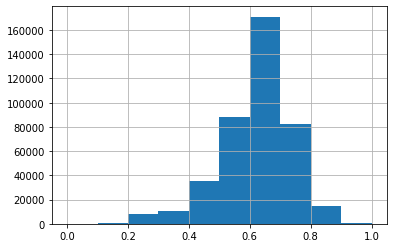

In [16]:
train.user_acc_mean.hist()
plt.show()

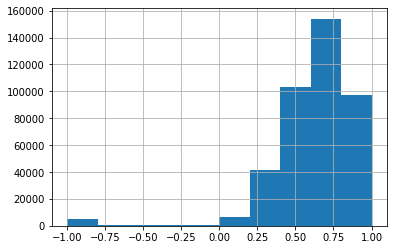

In [21]:
train.mean_content_accuracy.hist()
plt.show()

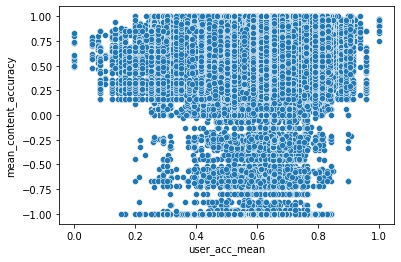

In [24]:
sns.scatterplot(train.user_acc_mean, train.mean_content_accuracy)
plt.show()

In [ ]:
sns.scatterplot(train.user_acc_mean, train.mean_content_accuracy)
plt.show()

### Drop rows and columns

In [25]:
train_scaled = MVP_Shi.drop_lecture_rows(train)
validate_scaled = MVP_Shi.drop_lecture_rows(validate)
test_scaled = MVP_Shi.drop_lecture_rows(test)

In [26]:
cols = ["user_id", "content_id", "content_type_id", "task_container_id", "user_answer"]


train_scaled = train_scaled.drop(columns=cols)
validate_scaled = validate_scaled.drop(columns=cols)
test_scaled = test_scaled.drop(columns=cols)

In [27]:
train_scaled.head()

,timestamp,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_acc_mean,user_lectures_running_total,last_q_time,avg_user_q_time,mean_content_accuracy,mean_task_accuracy,mean_timestamp_accuracy,mean_priortime_accuracy
0,0,1,0.0,False,0.630049,0,0.0,11917302.0,0.818182,0.682248,6.526086e+09,21594.667829
1,45951,0,0.0,False,0.630049,0,45951.0,11917302.0,0.550000,0.534988,6.526086e+09,21594.667829
2,74342,1,43000.0,False,0.630049,0,28391.0,11917302.0,0.444444,0.445216,6.526086e+09,21594.667829
3,96778,1,25000.0,False,0.630049,0,22436.0,11917302.0,0.406250,0.543241,6.526086e+09,21594.667829
4,132969,0,19000.0,False,0.630049,0,36191.0,11917302.0,0.687500,0.485282,6.526086e+09,21594.667829


### Fill the missing values

In [28]:
validate = MVP_Shi.fill_nulls(validate)
test = MVP_Shi.fill_nulls(test)

### Scale the columns

In [30]:
columns_to_scale = ['timestamp', 'prior_question_elapsed_time', 
                    'mean_timestamp_accuracy', 'mean_priortime_accuracy',
                    'user_lectures_running_total', 'avg_user_q_time']

scaler, train_scaled, validate_scaled, test_scaled = MVP_Shi.scale(train_scaled, 
                                                                   validate_scaled, 
                                                                   test_scaled, 
                                                                   columns_to_scale)

In [31]:
train_scaled.head()

,timestamp,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_acc_mean,last_q_time,mean_content_accuracy,mean_task_accuracy,timestamp_scaled,prior_question_elapsed_time_scaled,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,0,1,0.0,False,0.630049,0.0,0.818182,0.682248,0.000000e+00,0.000000,0.120073,0.500746,0.0,0.002404
1,45951,0,0.0,False,0.630049,45951.0,0.550000,0.534988,7.396404e-07,0.000000,0.120073,0.500746,0.0,0.002404
2,74342,1,43000.0,False,0.630049,28391.0,0.444444,0.445216,1.196630e-06,0.656489,0.120073,0.500746,0.0,0.002404
3,96778,1,25000.0,False,0.630049,22436.0,0.406250,0.543241,1.557766e-06,0.381679,0.120073,0.500746,0.0,0.002404
4,132969,0,19000.0,False,0.630049,36191.0,0.687500,0.485282,2.140307e-06,0.290076,0.120073,0.500746,0.0,0.002404


In [34]:
cols = ["timestamp", "prior_question_elapsed_time"]


train_scaled = train_scaled.drop(columns=cols)
validate_scaled = validate_scaled.drop(columns=cols)
test_scaled = test_scaled.drop(columns=cols)

### Convert the boolean values to 0 and 1

In [35]:
train_scaled = MVP_Shi.boolean_to_num(train_scaled)
validate_scaled = MVP_Shi.boolean_to_num(validate_scaled)
test_scaled = MVP_Shi.boolean_to_num(test_scaled)

In [36]:
train_scaled.head()

,answered_correctly,prior_question_had_explanation,user_acc_mean,last_q_time,mean_content_accuracy,mean_task_accuracy,timestamp_scaled,prior_question_elapsed_time_scaled,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,1,0,0.630049,0.0,0.818182,0.682248,0.000000e+00,0.000000,0.120073,0.500746,0.0,0.002404
1,0,0,0.630049,45951.0,0.550000,0.534988,7.396404e-07,0.000000,0.120073,0.500746,0.0,0.002404
2,1,0,0.630049,28391.0,0.444444,0.445216,1.196630e-06,0.656489,0.120073,0.500746,0.0,0.002404
3,1,0,0.630049,22436.0,0.406250,0.543241,1.557766e-06,0.381679,0.120073,0.500746,0.0,0.002404
4,0,0,0.630049,36191.0,0.687500,0.485282,2.140307e-06,0.290076,0.120073,0.500746,0.0,0.002404


### Seperate the features and target

In [37]:
X_train = train_scaled.drop(columns='answered_correctly')
y_train = train_scaled['answered_correctly']

In [38]:
X_train.head()

,prior_question_had_explanation,user_acc_mean,last_q_time,mean_content_accuracy,mean_task_accuracy,timestamp_scaled,prior_question_elapsed_time_scaled,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,0,0.630049,0.0,0.818182,0.682248,0.000000e+00,0.000000,0.120073,0.500746,0.0,0.002404
1,0,0.630049,45951.0,0.550000,0.534988,7.396404e-07,0.000000,0.120073,0.500746,0.0,0.002404
2,0,0.630049,28391.0,0.444444,0.445216,1.196630e-06,0.656489,0.120073,0.500746,0.0,0.002404
3,0,0.630049,22436.0,0.406250,0.543241,1.557766e-06,0.381679,0.120073,0.500746,0.0,0.002404
4,0,0.630049,36191.0,0.687500,0.485282,2.140307e-06,0.290076,0.120073,0.500746,0.0,0.002404


In [39]:
X_train.shape

(403377, 11)

### SelectKBset

In [40]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 4 features
f_selector = SelectKBest(f_regression, k=5)

# find the top 4 X's correlated with y
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()

f_feature

['prior_question_had_explanation',
 'user_acc_mean',
 'mean_content_accuracy',
 'mean_task_accuracy',
 'mean_priortime_accuracy_scaled']